## 读取TTM矩阵进行数据预处理

In [34]:
import os
import numpy as np
import re 
import fnmatch

file_path = './TTMs'

file_names = os.listdir(file_path)
# file_names.sort(key = lambda x:int(x.split('_')[1].split('.')[0]))

read_files = []
for file in file_names:
    if fnmatch.fnmatch(file, 'enron*'):
        read_files.append(file)

read_files.sort(key = lambda x:int(x.split('_')[2].split('.')[0]))


In [35]:
def load_TTM(read_files):
    TTMs = np.zeros((len(read_files), 64, 64))
    
    index_1 = 0
    index_2 = 0
    index_3 = 0
    for file in read_files:
        fr = open(file_path+'/'+file)
        for line in fr.readlines():
            if line[0] == '[':
                arr = line[1:-1]
                items_arr = arr.strip().split()
                for i in range(len(items_arr)):
                    TTMs[index_1, index_2, index_3] = float(items_arr[i])
                    index_3 += 1
            elif line[-2] == ']' :
                arr = line[0:-2]
                items_arr = arr.strip().split()
                for i in range(len(items_arr)):
                    TTMs[index_1, index_2, index_3] = float(items_arr[i])
                    index_3 += 1
                index_3 = 0
                index_2 += 1
            else:
                items_arr = line.strip().split()
                for i in range(len(items_arr)):
                    TTMs[index_1, index_2, index_3] = float(items_arr[i])
                    index_3 += 1
            if index_2 == 64:
                index_1 += 1
                index_2 = 0
    for i in range(len(read_files)):
        for j in range(64):
            for k in range(64):
                if np.isnan(TTMs[i,j,k]):
                    TTMs[i,j,k] = 1.0/64
    return TTMs
                

In [4]:
TTMs = load_TTM(read_files)


In [5]:
# normalizition
def nor_TTM(TTMs):
    N_TTMs = np.array(TTMs).reshape(len(TTMs), 4096)
    max_ = N_TTMs.max(axis=0).reshape(1, 4096)
    min_ = N_TTMs.min(axis=0).reshape(1,4096)
    max_min = max_ - min_
    new_TTMs = (N_TTMs - min_) / max_min
    
    for i in range(len(TTMs)):
        for j in range(4096):
            if np.isnan(new_TTMs[i,j]):
                new_TTMs[i,j] = 0
                
    return new_TTMs, min_, max_min
    

In [6]:
nor_TTMs, nor_min, nor_max_min= nor_TTM(TTMs)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [7]:
def constr_train_data(k, nor_TTMs):
    
    train_x, train_y = [], []
    dim = nor_TTMs.shape[1]
    for i in range(nor_TTMs.shape[0] - k):
        a = nor_TTMs[i:(i+k),:]
        train_x.append(a)
        temb = nor_TTMs[(i+k) ,:]
        train_y.append(temb)
    
    train_X = np.array(train_x, dtype = 'float64')
    train_Y = np.array(train_y, dtype = 'float64')
    
    return train_X, train_Y

In [8]:
train_X, train_Y = constr_train_data(3, nor_TTMs)

# 定义LSTM模型

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [10]:
def trainModel(trina_X, train_Y):
    model = models.Sequential()
    
    
    model.add(layers.LSTM(140, return_sequences = True, input_shape=(trina_X.shape[1], train_X.shape[2])))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(140, return_sequences = False))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(train_Y.shape[1]))
    model.add(layers.Activation('relu'))
    
    model.summary()
    return model
              

In [11]:
model = trainModel(train_X, train_Y)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 140)            2372720   
_________________________________________________________________
dropout (Dropout)            (None, 3, 140)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 140)               157360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              577536    
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
Tota

In [12]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
model.compile(loss='mse', optimizer = 'adam')
history = model.fit(train_X, train_Y, epochs=100, batch_size=16, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
48/48 [==============================] - 5s 95ms/sample - loss: 0.0519
Epoch 2/100
48/48 [==============================] - 0s 6ms/sample - loss: 0.0474
Epoch 3/100
48/48 [==============================] - 0s 7ms/sample - loss: 0.0431
Epoch 4/100
48/48 [==============================] - 0s 7ms/sample - loss: 0.0405
Epoch 5/100
48/48 [==============================] - 0s 6ms/sample - loss: 0.0389
Epoch 6/100
48/48 [==============================] - 0s 6ms/sample - loss: 0.0382
Epoch 7/100
32/48 [===================>..........] - ETA: 0s - loss: 0.0381

KeyboardInterrupt: 

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
#     val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
#     plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

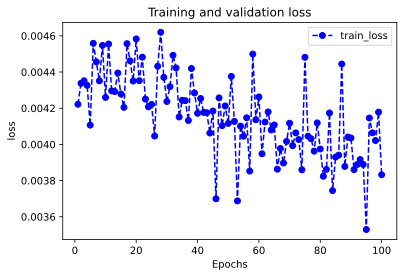

In [20]:
plot_metric(history, 'loss')

In [25]:
test_x = train_X[47].reshape(1,3,4096)
predict_y = model.predict(test_x)

In [27]:
predict_y.reshape(64,64)

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.89286304,  0.03870228,  0.12734058, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.937145  ,  0.22628915, -0.        , ...,  1.0023282 ,
         0.19260149, -0.        ],
       ...,
       [ 0.97500736, -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.13946255],
       [ 0.90189815, -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.5508564 , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.28226975]], dtype=float32)

In [28]:
model.save('./models/enron_model.h5')  

In [31]:
re_nor_predict_y = predict_y* nor_max_min + nor_min

In [33]:
re_nor_predict_y.reshape(64, 64)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.84297081e-01, 1.35351783e-01, 1.33410226e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.33786893e-01, 1.51358326e-04, 1.02680325e-01, ...,
        4.42378599e-06, 7.11602663e-06, 0.00000000e+00],
       ...,
       [6.33338111e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.78242841e-02],
       [5.02148532e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.42085610e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.52110311e-01]])

# clo_mg

In [36]:
import os
import numpy as np
import re 
import fnmatch

file_path = './new_sub/TTMs'

file_names = os.listdir(file_path)
# file_names.sort(key = lambda x:int(x.split('_')[1].split('.')[0]))

read_files = []
for file in file_names:
    if fnmatch.fnmatch(file, 'col*'):
        read_files.append(file)

read_files.sort(key = lambda x:int(x.split('_')[3].split('.')[0]))


In [38]:
col_TTMs = load_TTM(read_files)
col_nor_TTMs, col_nor_min, col_nor_max_min= nor_TTM(col_TTMs)
col_train_X, col_train_Y = constr_train_data(3, col_nor_TTMs)
history = model.fit(col_train_X, col_train_Y, epochs=100, batch_size=16, verbose=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Epoch 1/100
22/22 [==============================] - 0s 13ms/sample - loss: 0.2490
Epoch 2/100
22/22 [==============================] - 0s 9ms/sample - loss: 0.2182
Epoch 3/100
22/22 [==============================] - 0s 9ms/sample - loss: 0.1539
Epoch 4/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.1075
Epoch 5/100
22/22 [==============================] - 0s 11ms/sample - loss: 0.0937
Epoch 6/100
22/22 [==============================] - 0s 12ms/sample - loss: 0.0761
Epoch 7/100
22/22 [==============================] - 0s 14ms/sample - loss: 0.0686
Epoch 8/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0713
Epoch 9/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0681
Epoch 10/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0667
Epoch 11/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0616
Epoch 12/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0571
Epoch 13/

22/22 [==============================] - 0s 10ms/sample - loss: 0.0301
Epoch 100/100
22/22 [==============================] - 0s 10ms/sample - loss: 0.0341


In [42]:
history = model.fit(col_train_X, col_train_Y, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 9ms/sample - loss: 0.0281
Epoch 2/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0268
Epoch 3/100
22/22 [==============================] - 0s 9ms/sample - loss: 0.0277
Epoch 4/100
22/22 [==============================] - 0s 11ms/sample - loss: 0.0278
Epoch 5/100
22/22 [==============================] - 0s 9ms/sample - loss: 0.0273
Epoch 6/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0288
Epoch 7/100
22/22 [==============================] - 0s 9ms/sample - loss: 0.0276
Epoch 8/100
22/22 [==============================] - 0s 10ms/sample - loss: 0.0278
Epoch 9/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0270
Epoch 10/100
22/22 [==============================] - 0s 8ms/sample - loss: 0.0289
Epoch 11/100
22/22 [==============================] - 0s 11ms/sample - loss: 0.0287
Epoch 12/100
22/22 [==============================] - 0s 15ms/sample - loss: 0.0272
Epoch 13/

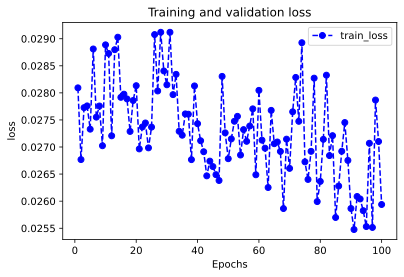

In [43]:
plot_metric(history, 'loss')


In [44]:
model.save('./models/col_mg_model.h5')  

In [36]:
read_files = []
for file in file_names:
    if fnmatch.fnmatch(file, 'email*'):
        read_files.append(file)

read_files.sort(key = lambda x:int(x.split('_')[3].split('.')[0]))
email_TTMs = load_TTM(read_files)
email_nor_TTMs, email_nor_min, email_nor_max_min= nor_TTM(email_TTMs)
email_train_X, email_train_Y = constr_train_data(3, email_nor_TTMs)

model_e = trainModel(train_X, train_Y)
model_e.compile(loss='mse', optimizer = 'adam')
# history = model_e.fit(train_X, train_Y, epochs=100, batch_size=16, verbose=1)

history = model_e.fit(email_train_X, email_train_Y, epochs=100, batch_size=16, verbose=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 3, 140)            2372720   
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 140)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 140)               157360    
_________________________________________________________________
dropout_15 (Dropout)         (None, 140)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              577536    
_________________________________________________________________
activation_7 (Activation)    (None, 4096)              0         
Total params: 3,107,616
Trainable params: 3,107,616
Non-trainable params: 0
____________________________________________

KeyboardInterrupt: 

Epoch 1/100
67/67 [==============================] - 1s 10ms/sample - loss: 0.0138
Epoch 2/100
67/67 [==============================] - 0s 7ms/sample - loss: 0.0131
Epoch 3/100
67/67 [==============================] - 1s 8ms/sample - loss: 0.0134
Epoch 4/100
67/67 [==============================] - 1s 9ms/sample - loss: 0.0131
Epoch 5/100
67/67 [==============================] - 1s 8ms/sample - loss: 0.0130
Epoch 6/100
67/67 [==============================] - 0s 7ms/sample - loss: 0.0132
Epoch 7/100
67/67 [==============================] - 0s 6ms/sample - loss: 0.0125
Epoch 8/100
67/67 [==============================] - 0s 7ms/sample - loss: 0.0126
Epoch 9/100
67/67 [==============================] - 0s 6ms/sample - loss: 0.0125
Epoch 10/100
67/67 [==============================] - 1s 8ms/sample - loss: 0.0128
Epoch 11/100
67/67 [==============================] - 0s 7ms/sample - loss: 0.0124
Epoch 12/100
67/67 [==============================] - 0s 7ms/sample - loss: 0.0127
Epoch 13/100

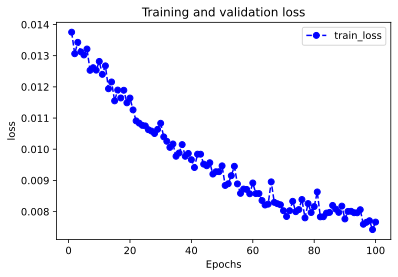

In [49]:
history = model_e.fit(email_train_X, email_train_Y, epochs=100, batch_size=16, verbose=1)
plot_metric(history, 'loss')


In [50]:

model.save('./models/email_model.h5')  

In [51]:
read_files = []
for file in file_names:
    if fnmatch.fnmatch(file, 'face*'):
        read_files.append(file)

read_files.sort(key = lambda x:int(x.split('_')[2].split('.')[0]))
f_TTMs = load_TTM(read_files)
f_nor_TTMs, f_nor_min, f_nor_max_min= nor_TTM(f_TTMs)
f_train_X, f_train_Y = constr_train_data(3, f_nor_TTMs)

model_e = trainModel(train_X, train_Y)
model_e.compile(loss='mse', optimizer = 'adam')
# history = model_e.fit(train_X, train_Y, epochs=100, batch_size=16, verbose=1)

history = model_e.fit(f_train_X, f_train_Y, epochs=100, batch_size=16, verbose=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 140)            2372720   
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 140)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 140)               157360    
_________________________________________________________________
dropout_5 (Dropout)          (None, 140)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              577536    
_________________________________________________________________
activation_2 (Activation)    (None, 4096)              0         
Total params: 3,107,616
Trainable params: 3,107,616
Non-trainable params: 0
____________________________________________

Epoch 87/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0389
Epoch 88/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0404
Epoch 89/100
8/8 [==============================] - 0s 12ms/sample - loss: 0.0369
Epoch 90/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0365
Epoch 91/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0378
Epoch 92/100
8/8 [==============================] - 0s 12ms/sample - loss: 0.0350
Epoch 93/100
8/8 [==============================] - 0s 13ms/sample - loss: 0.0339
Epoch 94/100
8/8 [==============================] - 0s 15ms/sample - loss: 0.0322
Epoch 95/100
8/8 [==============================] - 0s 13ms/sample - loss: 0.0325
Epoch 96/100
8/8 [==============================] - 0s 11ms/sample - loss: 0.0327
Epoch 97/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0320
Epoch 98/100
8/8 [==============================] - 0s 13ms/sample - loss: 0.0304
Epoch 99/100
8/8

Epoch 1/100
8/8 [==============================] - 0s 21ms/sample - loss: 0.0270
Epoch 2/100
8/8 [==============================] - 0s 20ms/sample - loss: 0.0275
Epoch 3/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0267
Epoch 4/100
8/8 [==============================] - 0s 21ms/sample - loss: 0.0270
Epoch 5/100
8/8 [==============================] - 0s 17ms/sample - loss: 0.0284
Epoch 6/100
8/8 [==============================] - 0s 12ms/sample - loss: 0.0260
Epoch 7/100
8/8 [==============================] - 0s 11ms/sample - loss: 0.0252
Epoch 8/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0240
Epoch 9/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0254
Epoch 10/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0229
Epoch 11/100
8/8 [==============================] - 0s 14ms/sample - loss: 0.0240
Epoch 12/100
8/8 [==============================] - 0s 15ms/sample - loss: 0.0227
Epoch 13/100
8/8 [=======

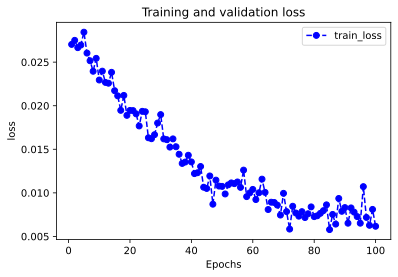

In [53]:
history = model_e.fit(f_train_X, f_train_Y, epochs=100, batch_size=16, verbose=1)
plot_metric(history, 'loss')



In [54]:
model.save('./models/facebook_model.h5')  

In [38]:
# artificial_network
read_files = []
for file in file_names:
    if fnmatch.fnmatch(file, 'art*'):
        read_files.append(file)

read_files.sort(key = lambda x:int(x.split('_')[2].split('.')[0]))
art_TTMs = load_TTM(read_files)

print(len(art_TTMs))
art_nor_TTMs, art_nor_min, art_nor_max_min= nor_TTM(art_TTMs)
art_train_X, art_train_Y = constr_train_data(3, art_nor_TTMs)
print(len(art_train_X))
print(len(art_train_Y))

model_a = trainModel(train_X, train_Y)
model_a.compile(loss='mse', optimizer = 'adam')
# history = model_e.fit(train_X, train_Y, epochs=100, batch_size=16, verbose=1)

history = model_a.fit(art_train_X, art_train_Y, epochs=100, batch_size=16, verbose=1)

12
9
9


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3, 140)            2372720   
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 140)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 140)               157360    
_________________________________________________________________
dropout_17 (Dropout)         (None, 140)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              577536    
_________________________________________________________________
activation_8 (Activation)    (None, 4096)              0         
Total params: 3,107,616
Trainable params: 3,107,616
Non-trainable params: 0
____________________________________________

Epoch 87/100
9/9 [==============================] - 0s 14ms/sample - loss: 0.0684
Epoch 88/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0691
Epoch 89/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0691
Epoch 90/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0693
Epoch 91/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0639
Epoch 92/100
9/9 [==============================] - 0s 12ms/sample - loss: 0.0666
Epoch 93/100
9/9 [==============================] - 0s 10ms/sample - loss: 0.0646
Epoch 94/100
9/9 [==============================] - 0s 10ms/sample - loss: 0.0648
Epoch 95/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0634
Epoch 96/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0660
Epoch 97/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0601
Epoch 98/100
9/9 [==============================] - 0s 11ms/sample - loss: 0.0598
Epoch 99/100
9/9

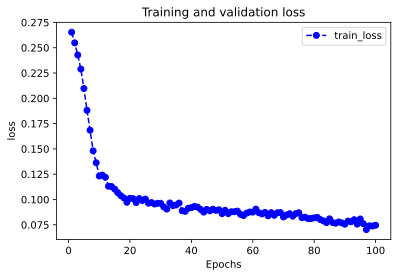

In [26]:
# history = model_e.fit(art_train_X, _train_Y, epochs=100, batch_size=16, verbose=1)
plot_metric(history, 'loss')



In [27]:

model.save('./models/art_model.h5')  

# 预测TTM

In [41]:
def predict_TTM(x, y, nor_min, nor_max_min, model_path, address):
    model = models.load_model(model_path)
    for i in range(len(x)):
        test_x = x[i].reshape(1,3,4096)
        predict_y = model.predict(test_x)
        renor_predict_y = predict_y * nor_max_min + nor_min
        renor_predict_y = renor_predict_y.reshape(64,64)
        fr = open('./predict_TTMs/' +address + str(i+3) + '_'+ str(i+4) + '.txt', 'w')
        for i in range(64):
            for j in range(64):
                fr.write(str(renor_predict_y[i,j]) + ' ')
            fr.write('\n')
        fr.close()

                         

In [63]:
predict_TTM(train_X, train_Y, nor_min, nor_max_min, './models/enron_model.h5', 'enron')

In [64]:
predict_TTM(col_train_X, col_train_Y, col_nor_min, col_nor_max_min, './models/col_mg_model.h5', 'col')

In [65]:
predict_TTM(email_train_X, email_train_Y, email_nor_min, email_nor_max_min, './models/email_model.h5', 'email')

In [66]:

predict_TTM(f_train_X, f_train_Y, f_nor_min, f_nor_max_min, './models/facebook_model.h5', 'facebook')


In [42]:
predict_TTM(art_train_X, art_train_Y, art_nor_min, art_nor_max_min, './models/art_model.h5', 'art')



In [40]:
len(art_train_Y)

9